## 3070 Northcote analysis
Just a quick, first thing that comes to the head, analysis of a particular area, in this case my home suburb of Northcote 3070.

In [1]:
import pandas as pd
from ggplot import *

project_id = "the-d-team-164512"

In [6]:
query = """\
SELECT
  COUNT(UNIQUE(t.patient_id)) AS number_unique_patients
FROM
  dthon.transactions t
  JOIN dthon.stores_lookup s
    ON s.store_id = t.store_id
WHERE
  s.postcode = 3070
"""

df_num = pd.read_gbq(query, project_id)
print("\n\nNumber of unique patients to any stores in 3070")
df_num

Waiting for job to complete...


Number of unique patients to any stores in 3070


,number_unique_patients
0,1387


In [7]:
query = """\
SELECT
  s.store_id as store_id
  , COUNT(UNIQUE(t.patient_id)) AS number_unique_patients
FROM
  dthon.transactions t
  JOIN dthon.stores_lookup s
    ON s.store_id = t.store_id
WHERE
  s.postcode = 3070
GROUP BY
  store_id
ORDER BY
  store_id
"""

df_num_patient = pd.read_gbq(query, project_id)
print("\n\nNumber of unique patients per store in 3070")
df_num_patient

Waiting for job to complete...


Number of unique patients per store in 3070


,store_id,number_unique_patients
0,943,675
1,1641,1010
2,2800,167


In [8]:
query = """\
    SELECT
      t2.patient_id AS patient_id
      , MAX(CASE WHEN s2.store_id == 943 THEN 1 END) as store_943
      , MAX(CASE WHEN s2.store_id == 1641 THEN 1 END) as store_1641
      , MAX(CASE WHEN s2.store_id == 2800 THEN 1 END) as store_2800
    FROM
      dthon.transactions t2
      JOIN dthon.stores_lookup s2
        ON s2.store_id = t2.store_id
    WHERE
      t2.patient_id IN 
      (SELECT t.patient_id AS patient_3070
        FROM dthon.transactions t
        JOIN dthon.stores_lookup s ON s.store_id = t.store_id
        WHERE s.postcode = 3070
        GROUP BY patient_3070)
      AND
        s2.postcode = 3070
    GROUP BY
      patient_id
"""

df_patient_per_store = pd.read_gbq(query, project_id)
print("\n\nATTEMPT at patients across the 3 stores in 3070")
df_patient_per_store.head(3)

Waiting for job to complete...


ATTEMPT at patients across the 3 stores in 3070


,patient_id,store_943,store_1641,store_2800
0,134251,1,1,NaN
1,425168,NaN,1,NaN
2,34790,NaN,1,NaN


In [16]:
query = """\
SELECT
store_id
, postcode
, AVG(distance) AS avg_distance
, NTH(4, quantiles(distance, 5)) seventy_fifth
FROM (
    SELECT
      s2.store_id AS store_id
      , s2.postcode AS postcode
      , t2.patient_id AS patient_id
      , pcd.distance AS distance
    FROM
        dthon.transactions t2
        JOIN dthon.patients_lookup p
            ON t2.patient_id = p.patient_id
        JOIN dthon.stores_lookup s2
            ON s2.store_id = t2.store_id
        JOIN dthon.postcodes pc
            ON p.postcode = pc.postcode
        JOIN dthon.postcode_distances pcd
            ON p.postcode = pcd.from_postcode AND s2.postcode = pcd.to_postcode
    WHERE
      t2.patient_id IN 
      (SELECT t.patient_id AS patient_3070
        FROM dthon.transactions t
        JOIN dthon.stores_lookup s ON s.store_id = t.store_id
        WHERE s.postcode = 3070
        GROUP BY patient_3070)
    GROUP BY
        store_id
        , postcode
        , patient_id
        , distance)
GROUP BY
    store_id
    , postcode
"""

df_patient_distance = pd.read_gbq(query, project_id)
print("\n\nother stores visited by patrons of 3070")
df_patient_distance.head(3)

Waiting for job to complete...
Waiting for job to complete...


other stores visited by patrons of 3070


,store_id,postcode,avg_distance,seventy_fifth
0,1081,3078,16.817102,4.588855
1,1613,4553,0.000000,0.000000
2,683,6050,3000.358275,3274.591392


In [20]:
df_patient_distance[df_patient_distance.postcode == 3070]

,store_id,postcode,avg_distance,seventy_fifth
194,1641,3070,42.242039,3.973267
563,2800,3070,51.284406,6.327146
564,943,3070,45.393628,3.973267


The average distance above has to be unfairly skewed by a coupld of distant visitors. To unscue could look at [distance decay](https://en.wikipedia.org/wiki/Distance_decay) or 75% quantile as above probably a good thing.

In [ ]:
query = """\
SELECT
  s2.store_id AS store_id
  , s2.postcode AS postcode
  , t2.patient_id AS patient_id
  , pcd.distance AS distance
FROM
    dthon.transactions t2
    JOIN dthon.patients_lookup p
        ON t2.patient_id = p.patient_id
    JOIN dthon.stores_lookup s2
        ON s2.store_id = t2.store_id
    JOIN dthon.postcodes pc
        ON p.postcode = pc.postcode
    JOIN dthon.postcode_distances pcd
        ON p.postcode = pcd.from_postcode AND s2.postcode = pcd.to_postcode
WHERE
  t2.patient_id IN 
  (SELECT t.patient_id AS patient_3070
    FROM dthon.transactions t
    JOIN dthon.stores_lookup s ON s.store_id = t.store_id
    WHERE s.postcode = 3070
    GROUP BY patient_3070)
GROUP BY
    store_id
    , postcode
    , patient_id
    , distance
"""

df_other_stores = pd.read_gbq(query, project_id)
print("\n\nother stores visited by patrons of 3070")
df_other_stores.head(3)

Waiting for job to complete...
Waiting for job to complete...


In [30]:
df_other_stores.store_id.unique()

array([ 943, 1641, 2800])

In [23]:
print("\n\n")
print("median:\n " + str(df_other_stores[df_other_stores['store_id'] == 2800].median()))
print("mean:\n " + str(df_other_stores[df_other_stores['store_id'] == 2800].mean()))
df_other_stores['store_name'] = pd.Series(df_other_stores.store_id).apply(lambda x: str(x) )
df_other_stores['store_name'] = pd.Series(df_other_stores.store_id).apply(lambda x: str(x) )
df_other_stores['dist_decay'] = pd.Series(df_other_stores.distance).apply(lambda x: 1/pow(x, 2) )
df_other_stores[df_other_stores['store_id'] == 2800].distance.quantile([0.25,0.75])
# ggplot(aes(x='store_name', y='distance'), data=df[df['store_id'] == 2800]) +\
#     geom_boxplot() +\
#     labs(title="Distribution of distance travelled")

# ggplot(aes(x='distance', y='store_id', colours='store_id'), data=df[df['store_id'] == 2800]) +\
#     geom_histogram(binwidth=10, alpha=0.4) +\
#     labs(title="Distribution of distance travelled")

# ggplot(aes(x='dist_decay', y='dist_decay'), data=df[df['store_id'] == 2800]) +\
#     geom_histogram(binwidth=100, alpha=0.4) +\
#     labs(title="Distribution of distance travelled")


# import numpy as np
# data = pd.DataFrame(np.random.randn(1,40)).transpose()
# data
# labels = np.repeat(['A','B'],20)
# data['labels']=labels
# data.columns = ['vals','labels']
# data
# ggplot(data, aes(x='vals', y='labels')) + geom_boxplot()

# bp = pd.DataFrame.boxplot(df, return_type='both')

# outliers = [flier.get_ydata() for flier in bp["fliers"]]
# boxes = [box.get_ydata() for box in bp["boxes"]]
# medians = [median.get_ydata() for median in bp["medians"]]
# whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]




median:
 store_id        2800.000000
postcode        3070.000000
patient_id    251684.500000
distance           2.763213
store_name      2800.000000
dist_decay         0.130970
dtype: float64
mean:
 store_id      2.800000e+03
postcode      3.070000e+03
patient_id    2.690586e+05
distance      5.128441e+01
store_name             inf
dist_decay             inf
dtype: float64


0.25    0.000000
0.75    6.327146
Name: distance, dtype: float64

Should be able to do a RMSE calculation or similar to skew the avearag to the more popoular but weaker closer distance?
* What about finance per shop
* drugs, users, finanace over time per shop
* share of patients, is there anything there?
* what about other stoers?
* is there a graph algorithm with other stores? connectedness? page rank/most influential store?
* how do we show a postcode and data on a graph?
* What happend to store 2080? did it shut down?
* what were the warning signs?
* any other trends? like predominant purchase periods, drugs, from a distance at particular time?
* can we get anything per person?
* are there any local things that can make an impact?
* how to expand this to the local area? RMS distance?
* how do other things found like lipitor replacement play out?
* how could we generalize for the store?
* how could we generalize for the patient?
* anything for the diabetes thing?
* compare to more and less affluent suburbs? by money, by vote, by age/demographics?

* how can we scale these findings to all the other stores, and ML it?

In [24]:
query = """\
SELECT
  t.store_id
  , DATE(STRFTIME_UTC_USEC(DATE(t.prescription_week), "%Y-%m-01")) AS year_month
  , GROUP_CONCAT(DATE(UNIQUE(t.dispense_week))) AS year_month_disp
  , COUNT(*) AS transaction_count
  , d.atclevel1code
--  , GROUP_CONCAT(UNIQUE(d.atclevel1code)) AS atc_codes
FROM
  dthon.transactions t
  JOIN dthon.stores_lookup s
    ON s.store_id = t.store_id
  JOIN dthon.drug_lookup d
    ON d.MasterProductID = t.Drug_ID
WHERE
  s.postcode = 3070
GROUP BY
  year_month
  , t.store_id
  , d.atclevel1code
ORDER BY
  year_month
  , t.store_id
"""

df_3070 = pd.read_gbq(query, project_id)
df_3070.head(3)

Waiting for job to complete...


,t_store_id,year_month,year_month_disp,transaction_count,d_atclevel1code
0,943,2010-01-01,"2011-01-09,2011-01-23",2,A
1,1641,2010-01-01,2011-01-09,1,A
2,1641,2010-01-01,"2011-01-02,2011-01-09,2011-01-23",3,C


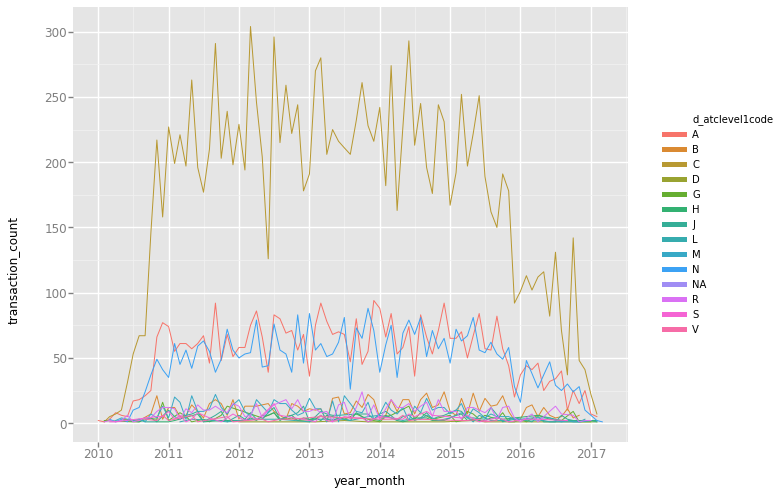

<ggplot: (284260630)>

In [25]:
df_3070.year_month = pd.Series(df_3070.year_month).apply(pd.to_datetime, format='%Y-%m')
df_3070['store_name'] = pd.Series(df_3070.t_store_id).apply(lambda x: str(x) )
df_3070[df_3070['store_name'] == '943'] # 943, 1641, 2800
# ggplot(
#     aes(x='year_month', y='transaction_count', colour='store_name'),
#     data=df_3070[['store_name', 'transaction_count', 'year_month']]) +\
#     geom_line()
ggplot(
    aes(x='year_month', y='transaction_count', colour='d_atclevel1code'),
    data=df_3070[df_3070['store_name'] == '943'][['d_atclevel1code', 'transaction_count', 'year_month']]) +\
    geom_line()

In [26]:
query = """\
SELECT
  STRING(t.store_id) AS store_id
  , p.patient_id
  , p.postcode
  , pcd.distance
  , DATE(STRFTIME_UTC_USEC(DATE(t.prescription_week), "%Y-%m-01")) AS year_month
  , GROUP_CONCAT(DATE(UNIQUE(t.dispense_week))) AS year_month_disp
  , COUNT(*) AS transaction_count
  , d.atclevel1code
FROM
  dthon.transactions t
  JOIN dthon.stores_lookup s
    ON s.store_id = t.store_id
  JOIN dthon.drug_lookup d
    ON d.MasterProductID = t.Drug_ID
  JOIN dthon.patients_lookup p
    ON t.patient_id = p.patient_id
  JOIN dthon.postcodes pc
    ON p.postcode = pc.postcode
  JOIN dthon.postcode_distances pcd
    ON p.postcode = pcd.from_postcode AND s.postcode = pcd.to_postcode
WHERE
  s.postcode = 3070
GROUP BY
  year_month
  , p.patient_id
  , p.postcode
  , pcd.distance
  , store_id
  , d.atclevel1code
ORDER BY
  year_month
  , store_id
"""
df_3070_p_dist = pd.read_gbq(query, project_id)
df_3070_p_dist.year_month = pd.Series(df_3070_p_dist.year_month).apply(pd.to_datetime, format='%Y-%m')
df_3070_p_dist.head(3)

Waiting for job to complete...
Waiting for job to complete...


,store_id,p_patient_id,p_postcode,pcd_distance,year_month,year_month_disp,transaction_count,d_atclevel1code
0,1641,266679,3070,0.000000,2010-01-01,2011-01-09,2,C
1,1641,278118,3070,0.000000,2010-01-01,2011-01-23,2,C
2,1641,519876,3071,2.763213,2010-01-01,2011-01-09,1,A


In [27]:
df_3070_p_dist[df_3070_p_dist.store_id == '2800'].groupby('p_patient_id').p_patient_id.unique()
df_3070_p_dist\
    [df_3070_p_dist['p_patient_id'] == 516505 ]\
    .groupby(['p_patient_id', 'store_id'])\
    .sum()
# pd.Series.unique()
# df_3070_p_dist[df_3070_p_dist.t_store_id == 2800].groupby('p_patient_id').p_patient_id.unique()

p_postcode  pcd_distance  transaction_count
p_patient_id store_id                                             
516505       1641           24560             0                 34
             2800           12280             0                 28
             943             3070             0                  2

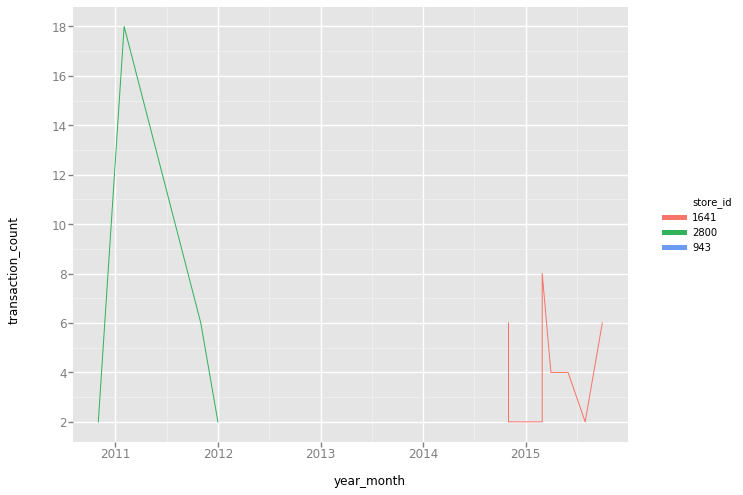

<ggplot: (-9223372036570895528)>

In [28]:
ggplot(
    aes(x='year_month', y='transaction_count', colour='store_id'),
    data=df_3070_p_dist[df_3070_p_dist['p_patient_id'] == 516505]\
    [['store_id', 'transaction_count', 'year_month']]) +\
    geom_line()